In [1]:
import os
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

In [2]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import anndata
import sklearn
import ot
import scipy
import meld
import sklearn.mixture
import scprep
import random
from IPython.display import display
from scipy.sparse import issparse
from os import listdir
from os.path import isfile, join
from scipy.stats import ks_2samp, anderson_ksamp
from scipy.stats import wasserstein_distance
from tqdm.notebook import tqdm
np.random.seed(42)

In [3]:
def load_ground_truth_data(dataset, spaces, cell_types, home_dir, condition_name, control, target):
    ground_truth_datasets = {}
    for space in spaces:
        if dataset == 'kaggle':
            if space == 'HVG':
                temp_adata = anndata.read_h5ad(home_dir + f'/datasets/cellot/kaggle_{space}_cellot.h5ad')
                temp_adata.var.index = temp_adata.var.gene_name
            else:
                print('loading data wrong')
                temp_adata = anndata.read_h5ad('/om2/user/dlesman/open_perturb_data/full_adata.h5ad')
                sc.pp.filter_cells(temp_adata, min_genes=200)
                sc.pp.filter_genes(temp_adata, min_cells=3)
                sc.pp.normalize_total(temp_adata, target_sum=1e4)
                sc.pp.log1p(temp_adata)
        elif dataset == 'sciplex':
            temp_adata = anndata.read_h5ad(home_dir + '/datasets/sciplex_complete_middle_subset.h5ad')
        temp_adata.obs['model_name'] = 'original'
        celltype_dict = {}
        for cell_type in cell_types:
            celltype_dict[f'{cell_type}'] = temp_adata[(temp_adata.obs['cell_type']==cell_type) & 
                    ((temp_adata.obs[condition_name]==control) | (temp_adata.obs[condition_name]==target))]
        ground_truth_datasets[space] = celltype_dict
    return ground_truth_datasets

def load_predictions(model_celltype_results_dict, ground_truth_datasets,
                                                     home_dir, condition_name, control, clip = False, round_ = False):
    predictions = {}
    for model, cell_type_to_paths in model_celltype_results_dict.items():
        celltype_predictions = {}
        for cell_type, result_path in cell_type_to_paths.items():
            full_path = f'{home_dir}{result_path}'
            #print(f'Loading {full_path}')
            if '.npz' in full_path:
                results = np.load(full_path)
                temp_adata = ground_truth_datasets['HVG'][cell_type][ground_truth_datasets['HVG'][cell_type].obs.sm_name == CONTROL].copy()
                if 'traj' in results:
                    temp_adata.X = results['traj']
                else:
                    temp_adata.X = results['pred_pert']
            else:
                temp_adata = anndata.read_h5ad(full_path)
            
            temp_adata.obs['model_name'] = model
            temp_adata.var.index = temp_adata.var.gene_name
            
            if clip:
                temp_adata.X = temp_adata.X.clip(min=0)
            
            if round_:
                temp_adata.X[temp_adata.X <= 0.5] = 0
            
            celltype_predictions[cell_type] = temp_adata
        predictions[f'{model}'] = celltype_predictions
    
    celltype_predictions = {}
    for cell_type, adata in ground_truth_datasets['HVG'].items():
        temp_adata = adata[adata.obs.sm_name == CONTROL].copy()
        temp_adata.obs['model_name'] = 'identity'
        temp_adata.var.index = temp_adata.var.gene_name
        celltype_predictions[cell_type] = temp_adata
    
    predictions['identity'] = celltype_predictions

    return predictions

In [4]:
def get_DEGs(adata, condition_name, control_name, target_name, meld = False):
    temp_adata = adata.copy()
    if meld:
        sample_likelihoods, classes = get_meld_labels(temp_adata, condition_name, control_name, target_name)
        temp_adata.obs['MELD_classes'] = classes
       
        # Identify cells both surrounded by other cells of the same condition and properly labelled
        enhanced_control = ((temp_adata.obs['MELD_classes'] == 0) & (temp_adata.obs[condition_name] == control_name))
        enhanced_target = ((temp_adata.obs['MELD_classes'] == 2) & (temp_adata.obs[condition_name] == target_name))
        
        enhanced_labels = list()
        for ctrl, trgt in zip(enhanced_control, enhanced_target):
            if (ctrl & trgt):
                print('SOMETHING IS VERY WRONG')
                break
            elif ctrl:
                enhanced_labels.append('0')
            elif trgt:
                enhanced_labels.append('1')
            else:
                enhanced_labels.append('-1')
        
        temp_adata.obs['enhanced_labels'] = enhanced_labels
        
        len_0 = len(temp_adata[temp_adata.obs['enhanced_labels'] == '0'])
        len_1 = len(temp_adata[temp_adata.obs['enhanced_labels'] == '1'])
        
        print(f'0: {len_0}')
        print(f'1: {len_1}')

        sc.tl.rank_genes_groups(temp_adata, 'enhanced_labels', method='wilcoxon', 
                            groups = ['1'], ref = '0', rankby_abs = True)
    
    else:
        sc.tl.rank_genes_groups(temp_adata, condition_name, method='wilcoxon', 
                            groups = [target_name], ref = control_name, rankby_abs = True)
    
    rankings = temp_adata.uns['rank_genes_groups']
    
    return rankings

In [5]:
def to_dense(X):
    if issparse(X):
        return X.toarray()
    else:
        return np.asarray(X)

In [6]:
def eval_DEGs(true_DEGs, pred_DEGs, DEG_vals):#true_slot_name, pred_slot_name, DEG_vals):

    #true_slot_name = true_DEGs['names'].dtype.names[0]
    #pred_slot_name = pred_DEGs['names'].dtype.names[0]
    
    true_DEGs_for_comparison = list()
    for gene, score in zip(true_DEGs.index, true_DEGs['scores']):
        direction = '+' if score > 0 else '-'
        true_DEGs_for_comparison.append(str(gene)+direction)
    
    pred_DEGs_for_comparison = list()
    for gene, score in zip(pred_DEGs.index, pred_DEGs['scores']):
        direction = '+' if score > 0 else '-'
        pred_DEGs_for_comparison.append(str(gene)+direction)

    results = {}
    for val in DEG_vals:
        results[f'Overlap_in_top_{val}_DEGs'] = len(set(true_DEGs_for_comparison[0:val]).intersection(set(pred_DEGs_for_comparison[0:val])))

    return results

In [7]:
def get_meld_labels(adata, condition_name, control_name, target_name):
    np.random.seed(42)
    sample_densities = meld.MELD().fit_transform(
        adata.X, 
        adata[(adata.obs[condition_name]==control_name) | (adata.obs[condition_name]==target_name)].obs[condition_name])
    sample_likelihoods = meld.utils.normalize_densities(sample_densities)
    mixture_model = sklearn.mixture.GaussianMixture(n_components=3)
    classes = mixture_model.fit_predict(sample_likelihoods[target_name].values.reshape(-1,1))
    classes = scprep.utils.sort_clusters_by_values(classes, sample_likelihoods[target_name])
    return sample_likelihoods, classes

In [8]:
def eval(true, pred, condition_name, condition, DEGs, DEG_vals, clip_pred = False):

    if clip_pred:
        pred.X = pred.X.clip(min=0)
        
    results_dict =  {}
    
    true_subset = true[true.obs[condition_name] == condition]
    true_subset.X = to_dense(true_subset.X)

    true_mean = to_dense(true_subset.X).mean(axis = 0)
    true_var = to_dense(true_subset.X).var(axis = 0)
    
    pred_mean = to_dense(pred.X).mean(axis = 0)
    pred_var = to_dense(pred.X).var(axis = 0)
    
    if len(true_subset.var) > 10000:
            pass
    else:
        true_corr_mtx = np.corrcoef(to_dense(true_subset.X), rowvar=False).flatten()
        true_cov_mtx = np.cov(to_dense(true_subset.X), rowvar=False).flatten()
        
        pred_corr_mtx = np.corrcoef(to_dense(pred.X), rowvar=False).flatten()
        pred_cov_mtx = np.cov(to_dense(pred.X), rowvar=False).flatten()

    results_dict['all_genes_mean_R2'] = scipy.stats.pearsonr(true_mean, pred_mean)[0]**2
    results_dict['all_genes_var_R2'] = scipy.stats.pearsonr(true_var, pred_var)[0]**2
    results_dict['all_genes_mean_MSE'] = (np.square(true_mean - pred_mean)).mean(axis=0)
    results_dict['all_genes_var_MSE'] = (np.square(true_var - pred_var)).mean(axis=0)

    if len(true_subset.var) > 10000:
        pass
   
    else:
        corr_nas = np.logical_or(np.isnan(true_corr_mtx), np.isnan(pred_corr_mtx))
        cov_nas = np.logical_or(np.isnan(true_cov_mtx), np.isnan(pred_cov_mtx))
        
        results_dict['all_genes_corr_mtx_R2'] = scipy.stats.pearsonr(true_corr_mtx[~corr_nas], pred_corr_mtx[~corr_nas])[0]**2
        results_dict['all_genes_cov_mtx_R2'] = scipy.stats.pearsonr(true_cov_mtx[~cov_nas], pred_cov_mtx[~cov_nas])[0]**2
        results_dict['all_genes_corr_mtx_MSE'] = (np.square(true_corr_mtx[~corr_nas] - pred_corr_mtx[~corr_nas])).mean(axis=0)
        results_dict['all_genes_cov_mtx_MSE'] = (np.square(true_cov_mtx[~cov_nas] - pred_cov_mtx[~cov_nas])).mean(axis=0)

    for val in DEG_vals:
        top_DEGs = DEGs[0:val].index
        
        true_mean = to_dense(true_subset[:,top_DEGs].X).mean(axis = 0)
        true_var = to_dense(true_subset[:,top_DEGs].X).var(axis = 0)
        true_corr_mtx = np.corrcoef(to_dense(true_subset[:,top_DEGs].X), rowvar=False).flatten()
        true_cov_mtx = np.cov(to_dense(true_subset[:,top_DEGs].X), rowvar=False).flatten()

        pred_mean = to_dense(pred[:,top_DEGs].X).mean(axis = 0)
        pred_var = to_dense(pred[:,top_DEGs].X).var(axis = 0)
        pred_corr_mtx = np.corrcoef(to_dense(pred[:,top_DEGs].X), rowvar=False).flatten()
        pred_cov_mtx = np.cov(to_dense(pred[:,top_DEGs].X), rowvar=False).flatten()

        results_dict[f'Top_{val}_DEGs_mean_R2'] = scipy.stats.pearsonr(true_mean, pred_mean)[0]**2
        results_dict[f'Top_{val}_DEGs_var_R2'] = scipy.stats.pearsonr(true_var, pred_var)[0]**2
        results_dict[f'Top_{val}_DEGs_mean_MSE'] = (np.square(true_mean - pred_mean)).mean(axis=0)
        results_dict[f'Top_{val}_DEGs_var_MSE'] = (np.square(true_var - pred_var)).mean(axis=0)
        
        corr_nas = np.logical_or(np.isnan(true_corr_mtx), np.isnan(pred_corr_mtx))
        cov_nas = np.logical_or(np.isnan(true_cov_mtx), np.isnan(pred_cov_mtx))
        
        results_dict[f'Top_{val}_DEGs_corr_mtx_R2'] = scipy.stats.pearsonr(true_corr_mtx[~corr_nas], pred_corr_mtx[~corr_nas])[0]**2
        results_dict[f'Top_{val}_DEGs_cov_mtx_R2'] = scipy.stats.pearsonr(true_cov_mtx[~cov_nas], pred_cov_mtx[~cov_nas])[0]**2
        results_dict[f'Top_{val}_DEGs_corr_mtx_MSE'] = (np.square(true_corr_mtx[~corr_nas] - pred_corr_mtx[~corr_nas])).mean(axis=0)
        results_dict[f'Top_{val}_DEGs_cov_mtx_MSE'] = (np.square(true_cov_mtx[~cov_nas] - pred_cov_mtx[~cov_nas])).mean(axis=0)

    return results_dict

In [9]:
def compute_pairwise_corrs(df):
    corr = df.corr().rename_axis(index='lhs', columns='rhs')
    print(corr)
    return (
        corr
        .where(np.triu(np.ones(corr.shape), k=1).astype(bool))
        .stack()
        .reset_index()
        .set_index(['lhs', 'rhs'])
        .squeeze()
        .rename()
    )

In [10]:
def rearrange_results_df(df, metric = 'all'):
    # Separate lists for each category
    mean_cols_R2 = [name for name in df.index if name.endswith('mean_R2')]
    mean_cols_MSE = [name for name in df.index if name.endswith('mean_MSE')]
    
    var_cols_R2 = [name for name in df.index if name.endswith('var_R2')]
    var_cols_MSE = [name for name in df.index if name.endswith('var_MSE')]
    
    corr_cols_R2 = [name for name in df.index if name.endswith('corr_mtx_R2')]
    corr_cols_MSE = [name for name in df.index if name.endswith('corr_mtx_MSE')]
    
    cov_cols_R2 = [name for name in df.index if name.endswith('cov_mtx_R2')]
    cov_cols_MSE = [name for name in df.index if name.endswith('cov_mtx_MSE')]

    # Combine sorted lists with desired order
    if metric == 'all':
        new_order = mean_cols_R2 + mean_cols_MSE + var_cols_R2 + var_cols_MSE + corr_cols_R2 + corr_cols_MSE + cov_cols_R2 + cov_cols_MSE
    elif metric == 'MSE':
        new_order = mean_cols_MSE + var_cols_MSE + corr_cols_MSE + cov_cols_MSE
    elif metric == 'R2':
        new_order = mean_cols_R2 + var_cols_R2 + corr_cols_R2 + cov_cols_R2
    else:
        print(f'METRIC: {metric} IS NOT AN OPTION')
    # Reorder the dataframe based on the new order
    df = df.loc[new_order]

    return(df)

In [11]:
def plot_comparison(true, pred, condition_name, condition, DEGs, model_name, DEG_val = None, clip_pred = False):
    
    true_subset = true[true.obs[condition_name] == condition]
    
    if DEG_val is not None:
        top_DEGs = DEGs.index[0:DEG_val]
        true_subset = true_subset[:,top_DEGs]
        pred = pred[:,top_DEGs]
        
    true_mean = to_dense(true_subset.X).mean(axis = 0)
    true_var = to_dense(true_subset.X).var(axis = 0)
    true_cov_mtx = np.cov(to_dense(true_subset.X), rowvar=False).flatten()

    if clip_pred:
        pred_mean = pred.X.clip(min=0).mean(axis = 0)
        pred_var = pred.X.clip(min=0).var(axis = 0)
        pred_corr_mtx = np.cov(pred.X.clip(min=0), rowvar=False).flatten()
    
    else:
        pred_mean = to_dense(pred.X).mean(axis = 0)
        pred_var = to_dense(pred.X).var(axis = 0)
        pred_cov_mtx = np.cov(to_dense(pred.X), rowvar=False).flatten()

    mean_data = (true_mean, pred_mean)
    var_data = (true_var, pred_var)
    
    nas = np.logical_or(np.isnan(true_cov_mtx), np.isnan(pred_cov_mtx))
    cov_data = (true_cov_mtx[~nas], pred_cov_mtx[~nas])
    
    num_rows = 1
    num_cols = 3
    fig, axs = plt.subplots(num_rows, num_cols, figsize=(12, 4))
    
    
    for i, (metric, data) in enumerate(zip(['gene mean', 'gene variance', 'gene covariance'],
                                        [mean_data, var_data, cov_data])):
        row = i // num_cols
        col = i % num_cols
        if num_rows == 1:
            axs[col].scatter(data[0],data[1], alpha=0.5)
            #axs[col].hexbin(data[0],data[1], gridsize=50, cmap='inferno', alpha=0.7, mincnt=1)
            axs[col].set_xlabel('ground truth')
            axs[col].set_ylabel('prediction')
            if DEG_val is None:
                axs[col].set_title(f'{model_name} {metric} for all genes',fontsize=9)
            else:
                axs[col].set_title(f'{model_name} {metric} for top {DEG_val} DEGs',fontsize=9)
        else:
            axs[row, col].scatter(data[0],data[1])
        plt.tight_layout()
    
    return fig

In [12]:
def sample_within_target(adata, cell_types, N_samples, sample_size, true_DEG_list, condition_column, control, target):
    sample_evals = {}
    sample_DEGs = {}
    for celltype in cell_types:
        print(celltype)
        temp_adata_control = adata[celltype][adata[celltype].obs[condition_column] == control]
        temp_adata_drug = adata[celltype][adata[celltype].obs[condition_column] == target]
        data_size = len(temp_adata_drug)
        celltype_evals = {}
        celltype_DEGs = {}
        for i in range(N_samples):
            true_sample = [random.randint(0, data_size-1) for _ in range(sample_size)]
            pred_sample = [random.randint(0, data_size-1) for _ in range(sample_size)]

            #print(temp_adata_drug[true_sample])
            #print(temp_adata_drug[pred_sample])
            celltype_evals[i] = eval(temp_adata_drug[true_sample], temp_adata_drug[pred_sample],
                                 condition_column, target,
                                    DEGs = true_DEG_list[celltype], DEG_vals = [500, 100, 50, 20], clip_pred = False)
            #print('finished celltype evals')
            DEG_results = get_DEGs(temp_adata_control, temp_adata_drug[pred_sample], method = 'wilcoxon')
            #temp_concat = anndata.concat([temp_adata_control, temp_adata_drug[pred_sample]], label = 'batch')
            
            #sc.tl.rank_genes_groups(temp_concat, 'batch', method='wilcoxon', 
            #                    groups = ['1'], ref = '0', rankby_abs = True)
            
            #rankings = temp_concat.uns['rank_genes_groups']
            celltype_DEGs[i] = DEG_results
            #print('finished celltype DEGs')
        sample_evals[celltype] = celltype_evals
        sample_DEGs[celltype] = celltype_DEGs
    return sample_evals, sample_DEGs

def get_DEGs(control_adata, target_adata, method):
    if method == 'wilcoxon':
        temp_concat = anndata.concat([control_adata, target_adata], label = 'batch')
        sc.tl.rank_genes_groups(temp_concat, 'batch', method=method, 
                                groups = ['1'], ref = '0', rankby_abs = True)

        rankings = temp_concat.uns['rank_genes_groups']
        result_df = pd.DataFrame({'scores': rankings['scores']['1'],
                     'pvals_adj': rankings['pvals_adj']['1']},
                    index = rankings['names']['1'])
        return result_df

    elif method == 'anderson':
        AD_stats = list()
        p_stats = list()
        for gene_id in control_adata.var.index:
            #print(control_adata[control_adata.obs[condition_name] == control][:,gene_id].X[:,0].shape)
            #print(target_adata[:,gene_id].X.shape)
            try:
                AD, _, p = anderson_ksamp([control_adata[:,gene_id].X[:,0], target_adata[:,gene_id].X[:,0]])
            except:
                AD, p = 0, 1
            AD_stats.append(AD)
            p_stats.append(p)
        
        result_df = pd.DataFrame({'scores': AD_stats,
                                 'pvals_adj': p_stats},
                                    index = control_adata.var.index).sort_values('scores', ascending = False)

        return result_df

    else:
        print(f'ERROR: {method} is not a valid method, must be "wilcoxon" or "anderson"')

In [13]:
def get_DEG_with_direction(gene, score):
    if score > 0:
        return(f'{gene}+')
    else:
        return(f'{gene}-')
        
def get_inter_celltype_DEG_intersections(true_DEGs_dict, all_pred_DEGs, DEG_vals):
    model_to_inter_celltype_DEG_intersections = {}
    for model, cell_type_to_pred_DEGs in all_pred_DEGs.items():
        model_to_DEG_num_intersection = {}
        for DEG_num in DEG_vals:
            all_overlaps = list()
            for cell_type, pred_DEGs in cell_type_to_pred_DEGs.items():
                #print(pred_DEGs)
                gene_list_1 = list()
                for gene, score in zip(pred_DEGs.index[0:DEG_num], pred_DEGs['scores'][0:DEG_num]):
                    gene_list_1.append(get_DEG_with_direction(gene,score))
                gene_set_1 = set(gene_list_1)
                
                for cell_type_2, pred_DEGs_2 in cell_type_to_pred_DEGs.items():
                    gene_list_2 = list()
                    for gene, score in zip(pred_DEGs_2.index[0:DEG_num], pred_DEGs_2['scores'][0:DEG_num]):
                        gene_list_2.append(get_DEG_with_direction(gene,score))
                    gene_set_2 = set(gene_list_2)
                    
                    all_overlaps.append(len(gene_set_1.intersection(gene_set_2)))
            
            cell_types_predicted = cell_type_to_pred_DEGs.keys()
            df = pd.DataFrame(np.array(all_overlaps).reshape(len(cell_types_predicted),
                                                             len(cell_types_predicted)),
                                                             columns = cell_types_predicted, 
                                                             index = cell_types_predicted)
            
            model_to_DEG_num_intersection[DEG_num] = df
        
        model_to_inter_celltype_DEG_intersections[model] = model_to_DEG_num_intersection
    return model_to_inter_celltype_DEG_intersections

In [14]:
def histogram_true_pred_DEG_expression(ground_truth_datasets, condition_name, control, target, predictions, true_DEGs_dict, cell_type_of_interest, DEG_num, sample_size = 500):
    num_rows = 4
    num_cols = int(DEG_num/4)
    ground_truth_samples = {}
    for model, cell_type_to_predictions in predictions.items():
        for cell_type, predictions in cell_type_to_predictions.items():
            ground_truth_ctrl = ground_truth_datasets[cell_type][ground_truth_datasets[cell_type].obs[condition_name] == control]
            ground_truth_trgt = ground_truth_datasets[cell_type][ground_truth_datasets[cell_type].obs[condition_name] == target]
            if cell_type == cell_type_of_interest:
                print(f'Prediction model: {model}, for celltype: {cell_type_of_interest}')
                top_DEGs = true_DEGs_dict[cell_type].index[0:DEG_num]
                fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 10))
                for i, gene in enumerate(top_DEGs):
                    # Get subsets and store them in dictionary so all comparisons use same data
                    if gene not in ground_truth_samples:
                        ground_truth_samples[gene] = {
                                'ctrl': np.random.choice(ground_truth_ctrl[:,gene].X[:,0], size = sample_size, replace=False),
                                'trgt': np.random.choice(ground_truth_trgt[:,gene].X[:,0], size = sample_size, replace=False)
                        }
                    row = i // num_cols
                    col = i % num_cols
                    ground_truth_points = ground_truth_samples[gene]['ctrl']
                    ground_truth_trgt_points = ground_truth_samples[gene]['trgt']
                    prediction_points = np.random.choice(predictions[:,gene].X[:,0], size = sample_size, replace=False)
                    
                    axs[row, col].hist(ground_truth_points, alpha = 0.5, label = 'True_ctrl')
                    axs[row, col].hist(ground_truth_trgt_points, alpha = 0.5, label = 'True_trgt')
                    axs[row, col].hist(prediction_points, alpha = 0.5, label = 'Pred')
                    
                    WD = wasserstein_distance(ground_truth_trgt_points, prediction_points)
                    axs[row, col].set_title(f'{gene}, Earth Movers: {WD:.3f}', fontsize = 10)
                    axs[row, col].legend()
                
                plt.show()

def get_earth_movers(ground_truth_datasets, condition_name, control, target, predictions, true_DEGs_dict, 
                     cell_type_of_interest, DEG_num, sample_size = 500, iters= 100):
    ground_truth_samples = {}
    final_results_dict = {}
    for model, cell_type_to_predictions in predictions.items():
        for cell_type, predictions in cell_type_to_predictions.items():
            ground_truth_trgt = ground_truth_datasets[cell_type][ground_truth_datasets[cell_type].obs[condition_name] == target]
            if cell_type == cell_type_of_interest:
                gene_to_WD = {}
                top_DEGs = true_DEGs_dict[cell_type].index[0:DEG_num]
                for gene in top_DEGs:
                    gene_to_WD[gene] = wasserstein_distance(ground_truth_trgt[:,gene].X[:,0], predictions[:,gene].X[:,0])
                    #WD_results = []
                    #if gene not in ground_truth_samples:
                    #    ground_truth_samples[gene] = {
                    #            'trgt': [np.random.choice(ground_truth_trgt[:,gene].X[:,0], size = sample_size, replace=False) for x in range(iters)]
                    #    }
                    #for i in range(iters):
                    #    prediction_points = np.random.choice(predictions[:,gene].X[:,0], size = sample_size, replace=False)
                    #    WD = wasserstein_distance(ground_truth_samples[gene]['trgt'][i], prediction_points)
                    #    WD_results.append(WD)
                   
                    #gene_to_WD[gene] = WD_results
        final_results_dict[model] = gene_to_WD
    return final_results_dict

In [15]:
# Path to home directory
HOME_DIR = '/orcd/archive/abugoot/001/Projects/njwfish'
dataset = 'kaggle'

In [16]:
if dataset == 'kaggle':
    CONDITION_NAME = 'sm_name'
    CONTROL = 'Dimethyl Sulfoxide'
    TARGET = 'Belinostat'
elif dataset == 'sciplex':
    CONDITION_NAME = 'drug_dose_name'
    CONTROL = 'control_1.0'
    TARGET = 'Belinostat_1.0'

In [17]:
# This is just code to make it easier to add your file paths
path_to_results = [f'{HOME_DIR}/scGen/predictions/', f'{HOME_DIR}/predictions/']
for path in path_to_results:
    files = [f for f in listdir(path) if isfile(join(path, f))]
    print(files)

['kaggle_B cells_Belinostat_pred.h5ad', 'kaggle_B cells_Belinostat_pred_MELD.h5ad', 'kaggle_Myeloid cells_Belinostat_pred.h5ad', 'kaggle_Myeloid cells_Belinostat_pred_MELD.h5ad', 'kaggle_NK cells_Belinostat_pred.h5ad', 'kaggle_NK cells_Belinostat_pred_MELD.h5ad', 'kaggle_T cells CD4+_Belinostat_pred.h5ad', 'kaggle_T cells CD4+_Belinostat_pred_MELD.h5ad', 'kaggle_T cells CD8+_Belinostat_pred.h5ad', 'kaggle_T cells CD8+_Belinostat_pred_MELD.h5ad', 'kaggle_T regulatory cells_Belinostat_pred.h5ad', 'kaggle_T regulatory cells_Belinostat_pred_MELD.h5ad', 'sciplex_middle_subset_A549_Belinostat_1.0_pred.h5ad', 'sciplex_middle_subset_K562_Belinostat_1.0_pred.h5ad', 'sciplex_middle_subset_MCF7_Belinostat_1.0_pred.h5ad']
['kaggle.X.identity.npz', 'kaggle.X.cmha.identity.npz', 'kaggle.X.cmlp.identity.npz', 'kaggle.X.cmha.identity.strat.npz', 'kaggle.X.cmlp.identity.strat.npz', 'kaggle.X.cmlp.identity.strat_new.npz', 'kaggle.X.cmha.identity.strat_new.npz', 'kaggle.X.cmha.identity.strat_new2.npz', '

In [18]:
if dataset == 'kaggle':
    model_celltype_results_dict = {
        'scGen_HVG': {# 'Myeloid cells': '/scGen/predictions/kaggle_Myeloid cells_Belinostat_pred.h5ad',
                      # 'NK cells': '/scGen/predictions/kaggle_NK cells_Belinostat_pred.h5ad',
                      # 'T regulatory cells': '/scGen/predictions/kaggle_T regulatory cells_Belinostat_pred.h5ad',
                      'B cells': '/scGen/predictions/kaggle_B cells_Belinostat_pred.h5ad',
                      # 'T cells CD8+': '/scGen/predictions/kaggle_T cells CD8+_Belinostat_pred.h5ad',
                      # 'T cells CD4+': '/scGen/predictions/kaggle_T cells CD4+_Belinostat_pred.h5ad'
        },
        'flow_HVG': {'B cells': '/predictions/kaggle.hvg.npz'},
        'ident_flow_HVG': {'B cells': '/predictions/kaggle.X.identity.npz'},
        'cmha_ident_flow_HVG': {'B cells': '/predictions/kaggle.X.cmha.identity.npz'},
        'cmlp_ident_flow_HVG': {'B cells': '/predictions/kaggle.X.cmlp.identity.npz'},
        # 'cmha_ident_strat_flow_HVG': {'B cells': '/predictions/kaggle.X.cmha.identity.strat.npz'},
        # 'cmlp_ident_strat_flow_HVG': {'B cells': '/predictions/kaggle.X.cmlp.identity.strat.npz'},
        # 'cmlp_ident_strat_new_flow_HVG': {'B cells': '/predictions/kaggle.X.cmlp.identity.strat_new.npz'},
        'cmlp_ident_strat_5_flow_HVG': {'B cells': '/predictions/kaggle.X.cmlp.identity.strat.5.npz'},
        'cmha_ident_strat_5_flow_HVG': {'B cells': '/predictions/kaggle.X.cmha.identity.strat.5.npz'},
        'cmlp_ident_strat_5k_flow_HVG': {'B cells': '/predictions/kaggle.X.cmlp.identity.strat.5k.npz'},
        # 'cmha_ident_strat_new_flow_HVG': {'B cells': '/predictions/kaggle.X.cmha.identity.strat_new.npz'},
        # 'cmlp_ident_strat_4_flow_HVG': {'B cells': '/predictions/kaggle.X.cmlp.identity.strat.4.npz'},
        # 'cmha_ident_strat_4_flow_HVG': {'B cells': '/predictions/kaggle.X.cmha.identity.strat.4.npz'}
        
    }
elif dataset == 'sciplex':
    model_celltype_results_dict = {
        'scGen_HVG':    f'/scGen/predictions/sciplex_middle_subset_FILLER_Belinostat_1.0_pred.h5ad',
    }

In [19]:
spaces = ['HVG']#,'raw','scvi','scgpt']
models = ['scGen', 'flow']#, 'scGenMELD']#'cellOT','scVIDR', 'scPreGAN']

In [20]:
cell_types = ["B cells", "Myeloid cells", "NK cells",
                "T regulatory cells", "T cells CD4+", "T cells CD8+"]
#cell_types = ['A549', 'K562', 'MCF7']

In [21]:
ground_truth_datasets = load_ground_truth_data(dataset, spaces, cell_types, HOME_DIR, CONDITION_NAME, CONTROL, TARGET)

predictions = load_predictions(model_celltype_results_dict, ground_truth_datasets,
                                                     HOME_DIR, CONDITION_NAME, CONTROL, round_ = True)

In [22]:
DEG_METHOD = 'wilcoxon'

In [23]:
true_DEGs_dict = {}
for space in spaces:
    per_space_DEGs_dict = {}
    for celltype, adata in ground_truth_datasets[space].items():
        control = adata[adata.obs[CONDITION_NAME] == CONTROL]
        target = adata[adata.obs[CONDITION_NAME] == TARGET]
        temp_DEGs = get_DEGs(control, target, DEG_METHOD)
        per_space_DEGs_dict[celltype] = temp_DEGs
    true_DEGs_dict[space] = per_space_DEGs_dict

In [24]:
all_pred_DEGs = {}
for model, celltypes_predictions in predictions.items():
    model_pred_DEGs = {}
    for celltype in cell_types:
        if celltype in celltypes_predictions:
            ground_truth_adata = ground_truth_datasets['HVG'][celltype]
            control = ground_truth_adata[ground_truth_adata.obs[CONDITION_NAME] == CONTROL]
            target = celltypes_predictions[celltype]
            result = get_DEGs(control, target, DEG_METHOD)
            model_pred_DEGs[celltype] = result
    all_pred_DEGs[model] = model_pred_DEGs

/om2/user/njwfish/anaconda/envs/dsbm/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/om2/user/njwfish/anaconda/envs/dsbm/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/om2/user/njwfish/anaconda/envs/dsbm/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/om2/user/njwfish/anaconda/envs/dsbm/lib/python3.10/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/om2/user/njwfish/anaconda/envs/dsbm/lib/python3.10/site-packages/an

In [25]:
# Earth Mover's distance for top DEGs
results_no_sample = get_earth_movers(ground_truth_datasets = ground_truth_datasets['HVG'], 
                                   condition_name = CONDITION_NAME, control = CONTROL, target = TARGET,
                                   predictions = predictions, 
                                   true_DEGs_dict = true_DEGs_dict['HVG'], cell_type_of_interest = 'B cells', 
                                   DEG_num = 20, sample_size = 500, iters = 100)
earth_movers_dict = {key: list(val.values()) for key,val in results_no_sample.items()}
earth_movers_results = pd.DataFrame(earth_movers_dict, index = results_no_sample['flow_HVG'].keys())
earth_movers_results.columns = [x.replace('_flow','').replace('_HVG','').replace('_',' ') for x in earth_movers_results.columns]
display(earth_movers_results)

,scGen,flow,ident,cmha ident,cmlp ident,cmlp ident strat 5,cmha ident strat 5,cmlp ident strat 5k,identity
RPS18,0.348555,0.239753,0.226136,0.331774,0.842852,0.545066,0.471737,0.478551,0.509077
ISG20,0.714985,0.398960,0.333347,0.878514,0.499187,1.189224,0.978100,1.166298,1.195435
CD74,0.162356,0.180453,0.216068,0.340934,0.931000,0.495978,0.442729,0.545977,0.601325
TMSB10,0.375763,0.049455,0.059586,0.334255,0.561749,0.513438,0.422812,0.488299,0.623057
CD79A,0.601012,0.948035,0.919771,0.797952,0.301545,0.911698,0.904156,0.939179,0.970497
CD37,0.428423,0.388266,0.259723,0.609859,0.238815,0.853611,0.634722,0.818582,0.821520
B2M,0.194790,0.040721,0.018477,0.219927,0.358595,0.359103,0.292670,0.293978,0.343153
HLA-DRA,0.035214,0.297318,0.450093,0.222577,1.155496,0.417562,0.411921,0.460529,0.492434
HLA-DPB1,0.195020,0.272061,0.117099,0.363326,0.737280,0.456599,0.474077,0.490800,0.579701
IFI44L,0.300107,0.329508,0.282794,0.805502,0.752453,0.924206,0.839871,0.886913,0.964262


Prediction model: scGen_HVG, for celltype: B cells


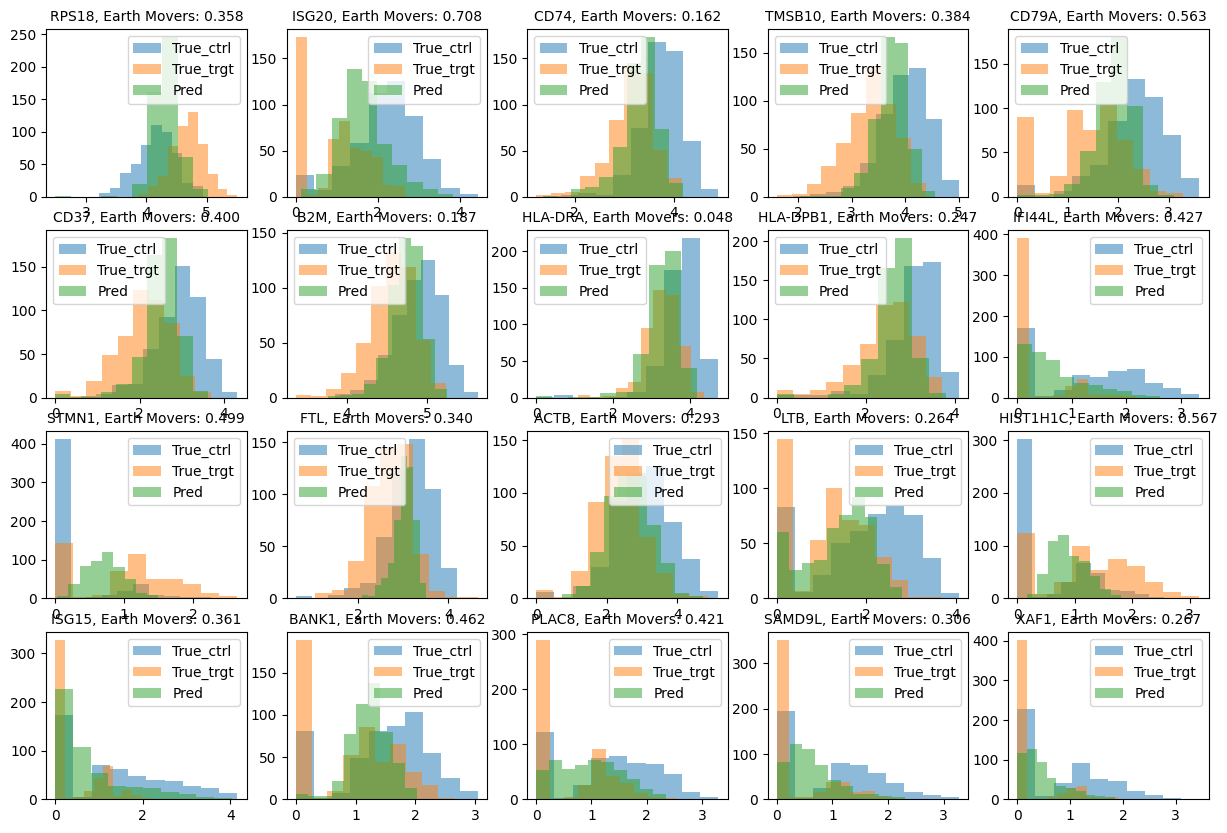

Prediction model: flow_HVG, for celltype: B cells


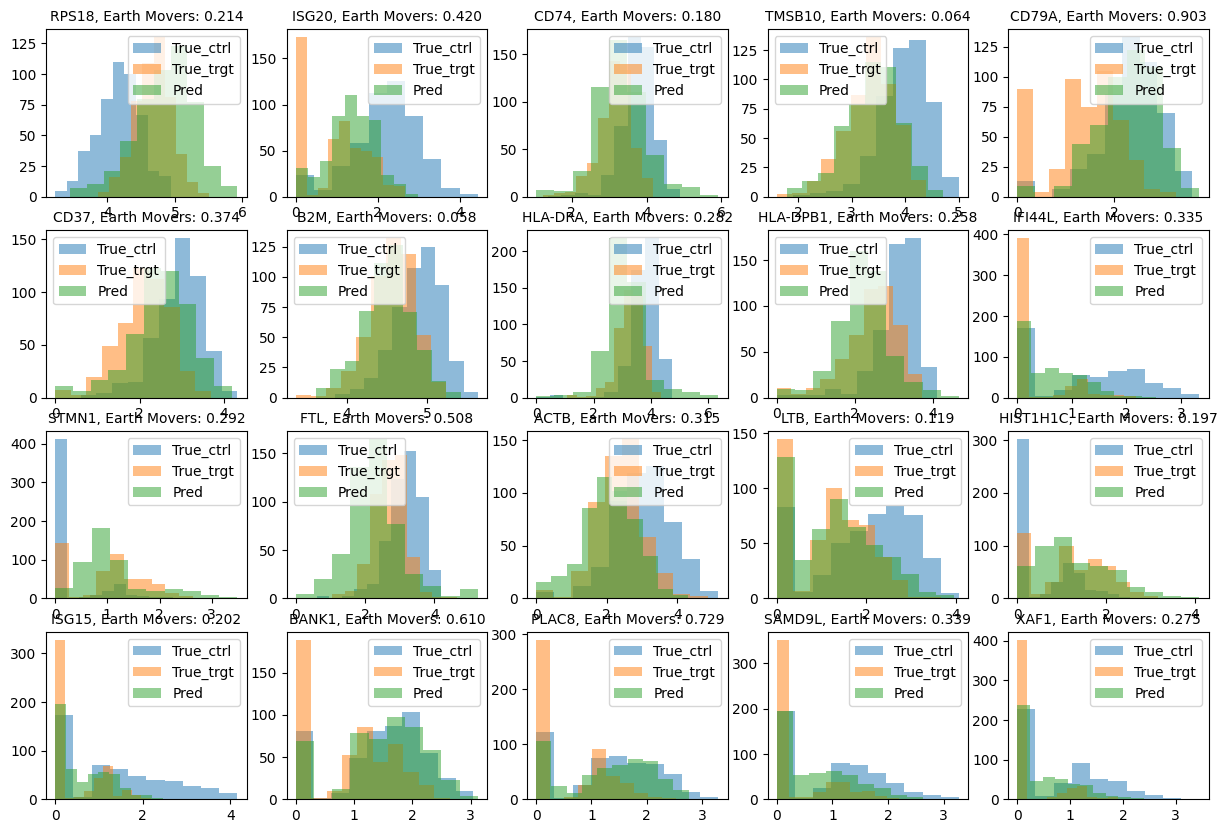

Prediction model: ident_flow_HVG, for celltype: B cells


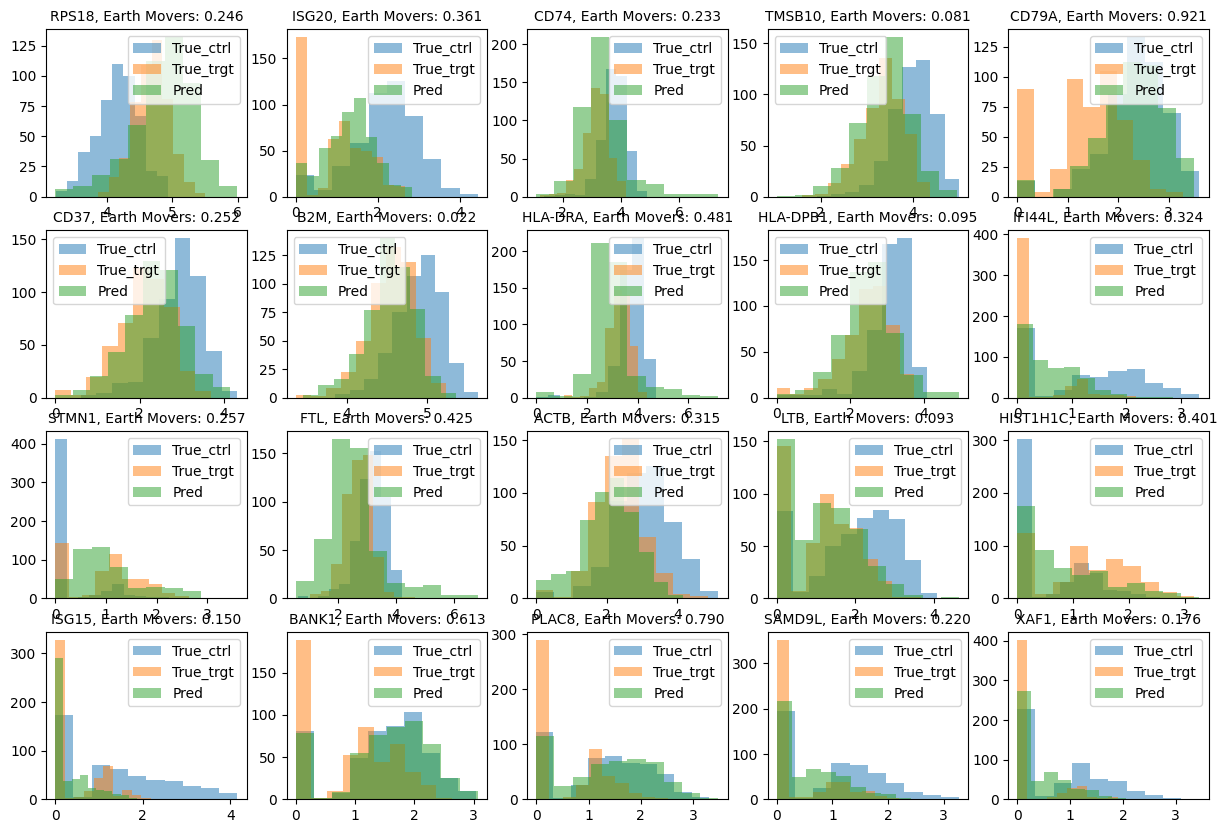

Prediction model: cmha_ident_flow_HVG, for celltype: B cells


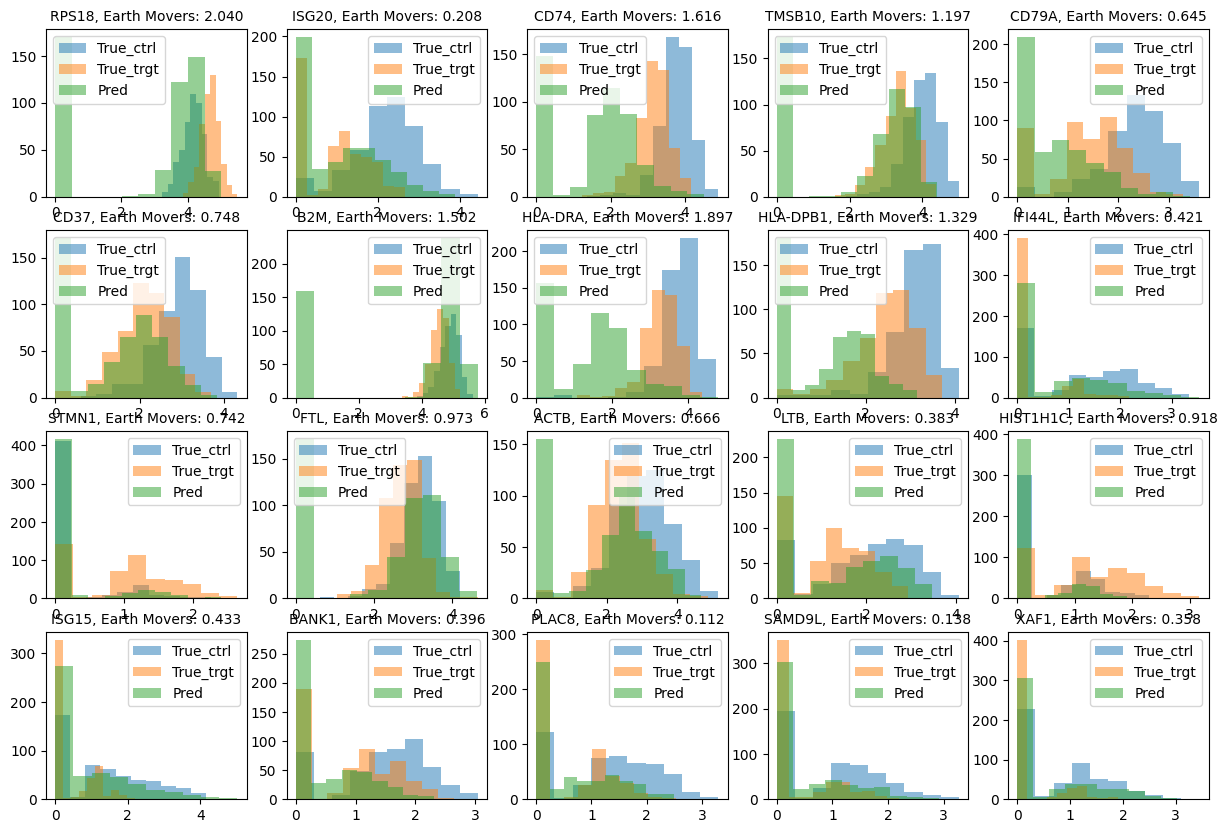

Prediction model: cmlp_ident_flow_HVG, for celltype: B cells


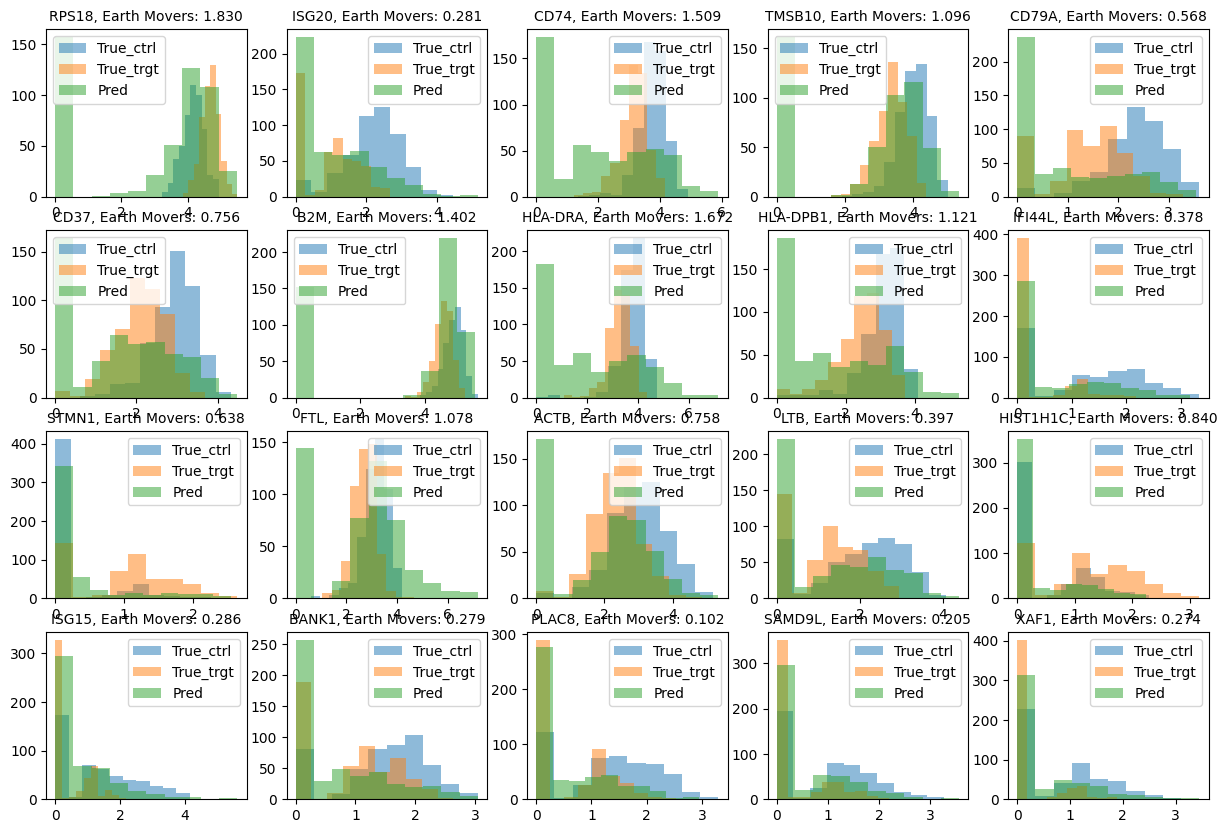

Prediction model: cmha_ident_strat_flow_HVG, for celltype: B cells


Exception ignored in: <function _xla_gc_callback at 0x153d8631cca0>
Traceback (most recent call last):
  File "/om2/user/njwfish/anaconda/envs/dsbm/lib/python3.10/site-packages/jax/_src/lib/__init__.py", line 98, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


KeyboardInterrupt: 

In [61]:
histogram_true_pred_DEG_expression(ground_truth_datasets = ground_truth_datasets['HVG'], 
                                   condition_name = CONDITION_NAME, control = CONTROL, target = TARGET,
                                   predictions = predictions, 
                                   true_DEGs_dict = true_DEGs_dict['HVG'], cell_type_of_interest = 'B cells', 
                                   DEG_num = 20, sample_size = 500)

In [30]:
meld_pred_scGen_DEGs_dict = {}
for celltype, adata in merged_adatas.items():
    meld_pred_scGen_DEGs = get_DEGs(adata[adata.obs[CONDITION_NAME] == CONTROL], 
                                'model_name', 'original', 'scGen_HVG', meld = True)
    meld_pred_scGen_DEGs_dict[celltype.split('_')[3]] = meld_pred_scGen_DEGs

NameError: name 'merged_adatas' is not defined

# Eval Metrics

In [26]:
num_true_DEGs = len(true_DEGs_dict['HVG']['B cells'][true_DEGs_dict['HVG']['B cells']['pvals_adj'] < 0.05])
print(num_true_DEGs)

395


In [27]:
model_evals_dict = {}
cell_type = 'B cells'
for model, predicted_adata in predictions.items():
    identity_eval = eval(ground_truth_datasets['HVG'][cell_type], predicted_adata[cell_type], 
                        CONDITION_NAME, TARGET, DEGs = true_DEGs_dict['HVG'][cell_type], 
                        DEG_vals = [395, 100, 50, 20], clip_pred = False)
    model_evals_dict[model] = identity_eval

/om2/user/njwfish/anaconda/envs/dsbm/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/om2/user/njwfish/anaconda/envs/dsbm/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/om2/user/njwfish/anaconda/envs/dsbm/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: divide by zero encountered in divide
  c /= stddev[:, None]
/om2/user/njwfish/anaconda/envs/dsbm/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/om2/user/njwfish/anaconda/envs/dsbm/lib/python3.10/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/om2/user/njwfish/anaconda/envs/dsbm/lib/python3.10/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value 

In [28]:
evals_df = pd.DataFrame({mode: eval.values() for mode, eval in model_evals_dict.items()}, index = model_evals_dict['identity'].keys())
evals_df.columns = [x.replace('_flow','').replace('_HVG','').replace('_',' ') for x in evals_df.columns]
display(rearrange_results_df(evals_df, metric = 'R2'))
display(rearrange_results_df(evals_df, metric = 'MSE'))

,scGen,flow,ident,cmha ident,cmlp ident,cmlp ident strat 5,cmha ident strat 5,cmlp ident strat 5k,identity
all_genes_mean_R2,0.956652,0.959916,0.966557,0.961035,0.886332,0.951208,0.957093,0.953259,0.946662
Top_395_DEGs_mean_R2,0.959419,0.951856,0.957179,0.947167,0.887589,0.933289,0.941880,0.936806,0.928307
Top_100_DEGs_mean_R2,0.968371,0.949887,0.952519,0.946434,0.911352,0.926720,0.938435,0.931249,0.922326
Top_50_DEGs_mean_R2,0.969918,0.944798,0.950530,0.947930,0.888758,0.922386,0.937193,0.928589,0.920766
Top_20_DEGs_mean_R2,0.958445,0.948708,0.942252,0.910945,0.861779,0.859392,0.888966,0.869873,0.856704
all_genes_var_R2,0.755299,0.907625,0.900776,0.889849,0.509431,0.884648,0.890333,0.897204,0.867976
Top_395_DEGs_var_R2,0.804173,0.878104,0.875433,0.832812,0.385389,0.821203,0.832251,0.841343,0.794813
Top_100_DEGs_var_R2,0.279070,0.569050,0.505975,0.344284,0.068862,0.327947,0.363517,0.363103,0.246032
Top_50_DEGs_var_R2,0.120606,0.537064,0.434246,0.202550,0.008547,0.203580,0.233750,0.215918,0.115763
Top_20_DEGs_var_R2,0.112709,0.539145,0.315367,0.258345,0.011221,0.223494,0.271128,0.222570,0.168715


,scGen,flow,ident,cmha ident,cmlp ident,cmlp ident strat 5,cmha ident strat 5,cmlp ident strat 5k,identity
all_genes_mean_MSE,0.008124,0.006748,0.005660,0.007253,0.022438,0.010034,0.008832,0.009702,0.011683
Top_395_DEGs_mean_MSE,0.031931,0.028650,0.025669,0.036131,0.074907,0.050283,0.044176,0.048643,0.058676
Top_100_DEGs_mean_MSE,0.048903,0.082711,0.076163,0.115974,0.169159,0.170591,0.146629,0.163613,0.199957
Top_50_DEGs_mean_MSE,0.064852,0.118569,0.103394,0.181572,0.250235,0.280408,0.235023,0.266772,0.325900
Top_20_DEGs_mean_MSE,0.114340,0.131944,0.122089,0.275274,0.342590,0.472000,0.368406,0.437325,0.520985
all_genes_var_MSE,0.010945,0.003655,0.004170,0.004203,0.040719,0.004993,0.005315,0.004797,0.006767
Top_395_DEGs_var_MSE,0.043241,0.014620,0.015706,0.020225,0.138046,0.024406,0.025212,0.023282,0.033018
Top_100_DEGs_var_MSE,0.058357,0.030210,0.035487,0.052840,0.397835,0.066926,0.067210,0.061286,0.093503
Top_50_DEGs_var_MSE,0.057073,0.032228,0.041864,0.071613,0.669418,0.094181,0.091493,0.083246,0.125476
Top_20_DEGs_var_MSE,0.069388,0.030142,0.047654,0.068065,0.963163,0.107301,0.101305,0.089016,0.124349


<Axes: >

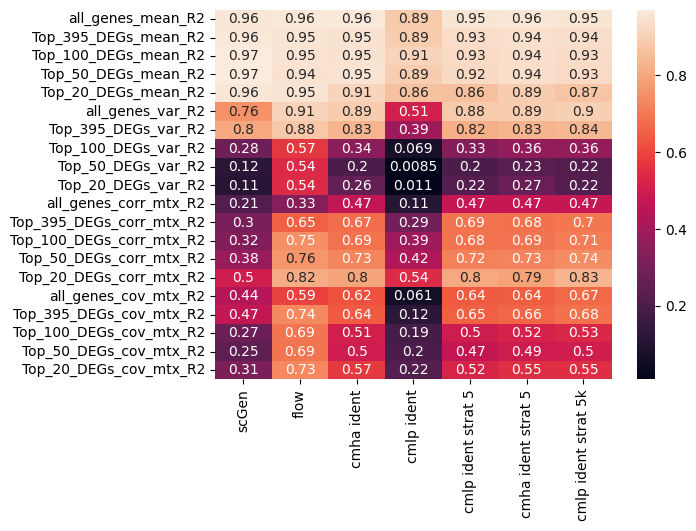

In [33]:
import seaborn as sns
hm = rearrange_results_df(evals_df, metric = 'R2')[['scGen', 'flow', 'cmha ident', 'cmlp ident', 'cmlp ident strat 5', 'cmha ident strat 5', 'cmlp ident strat 5k']]
sns.heatmap(hm, annot=True)

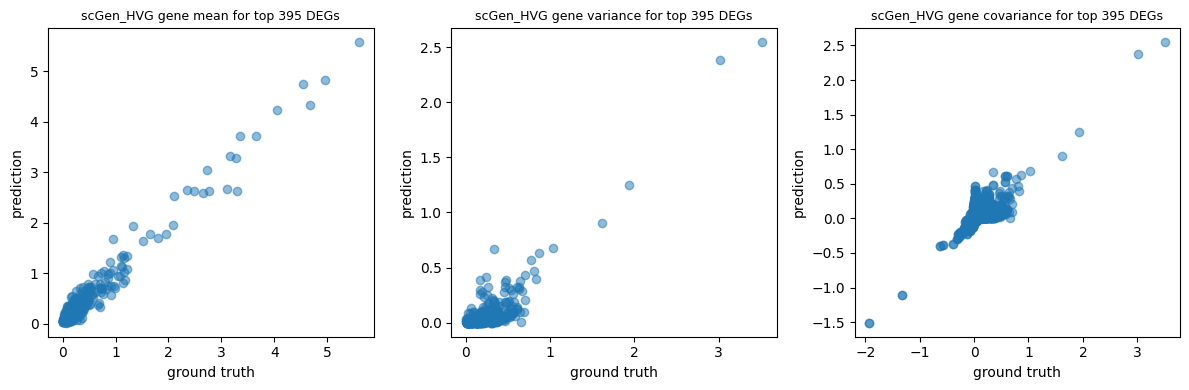

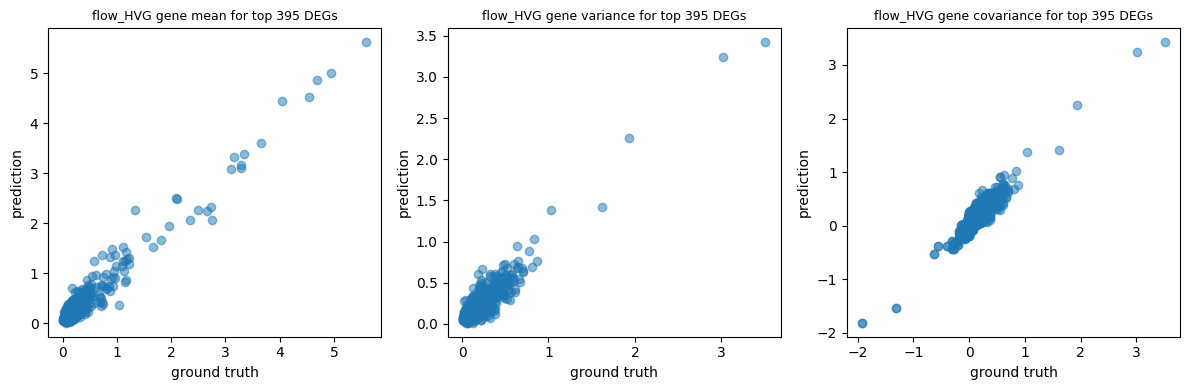

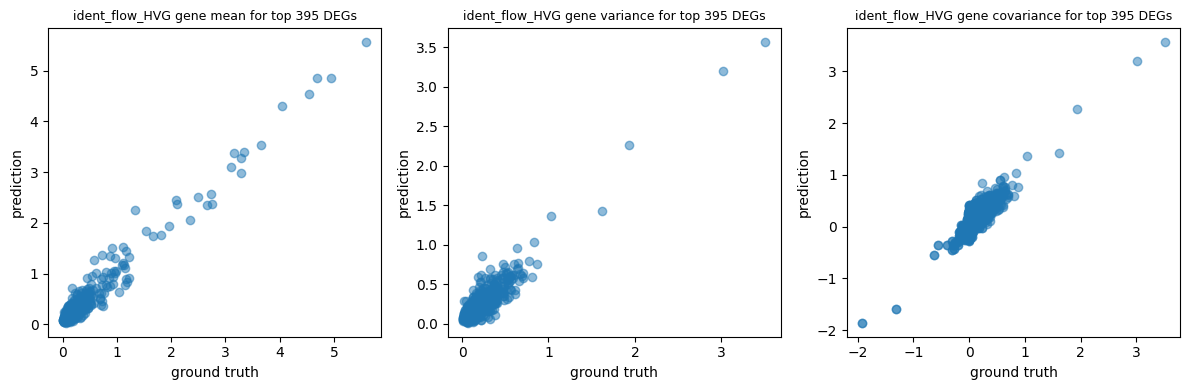

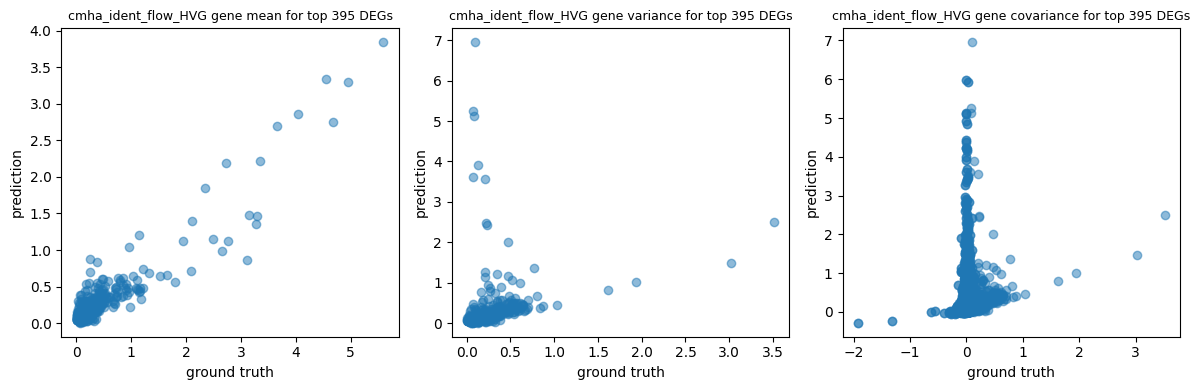

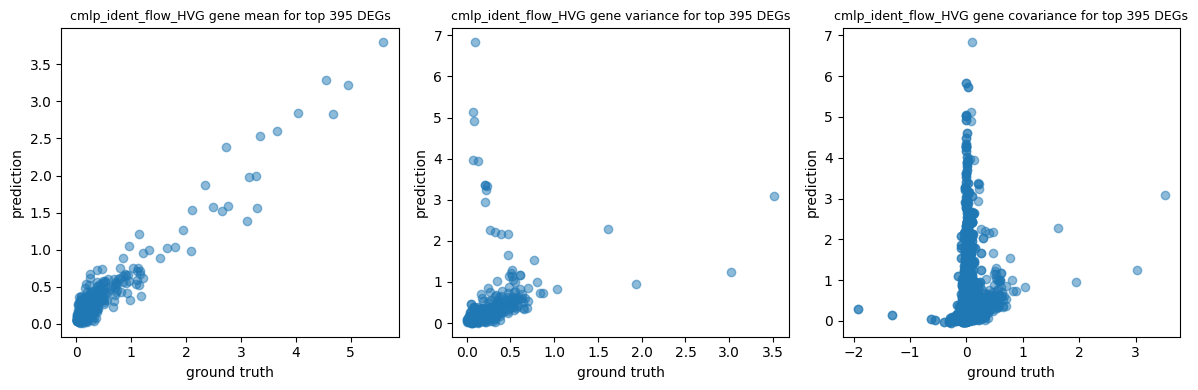

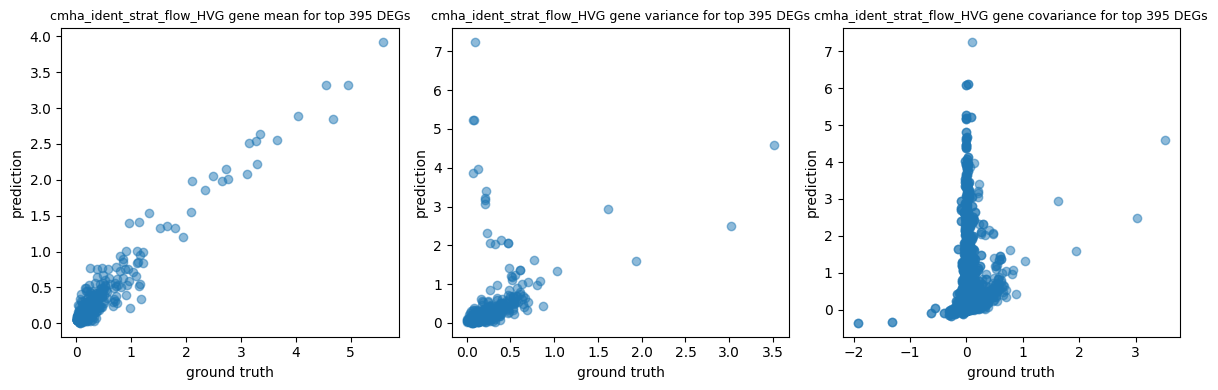

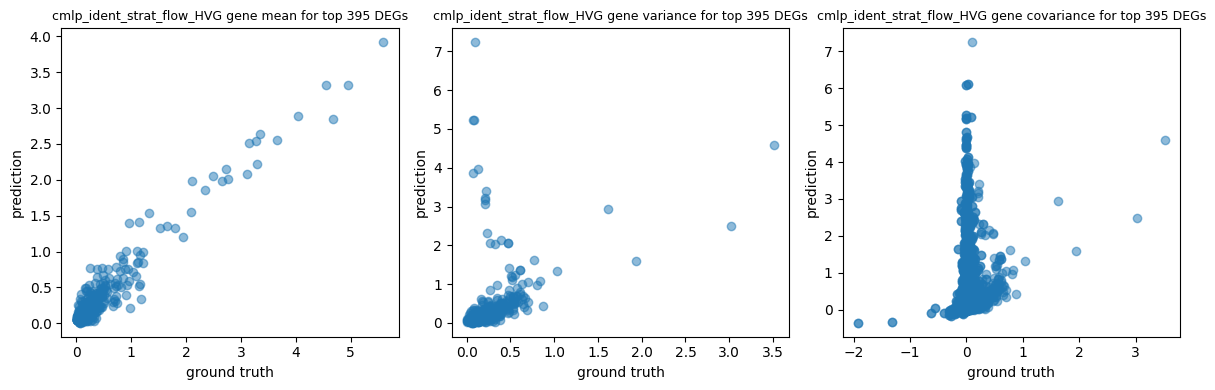

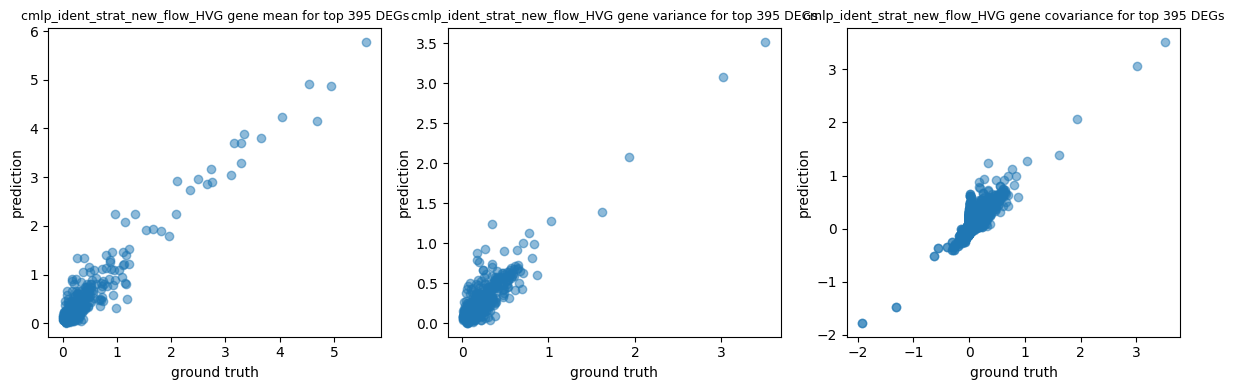

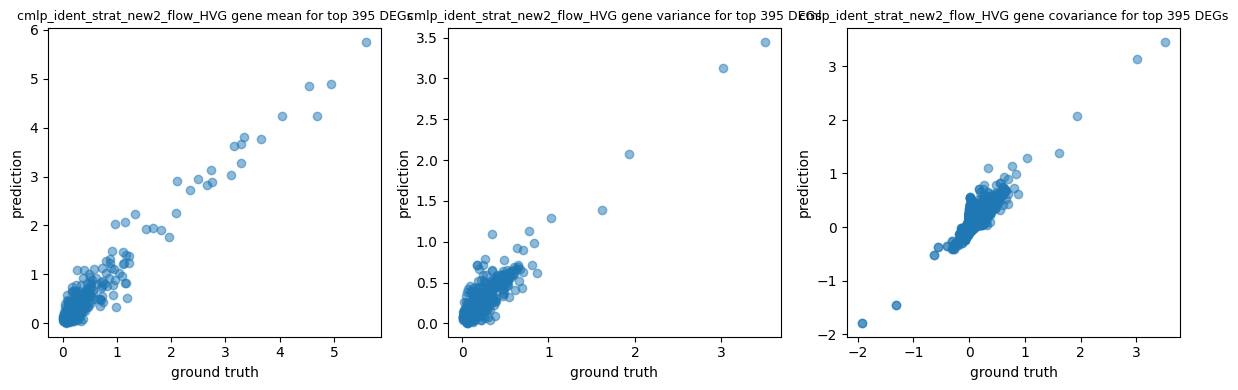

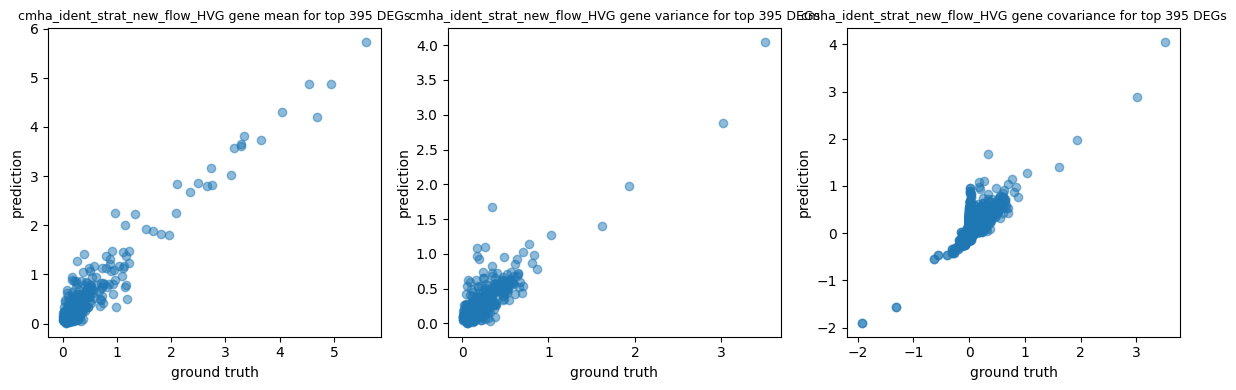

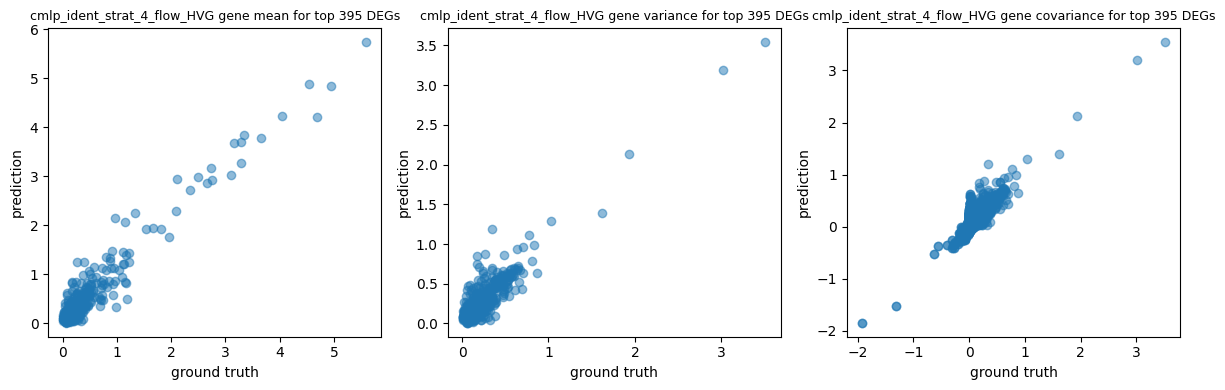

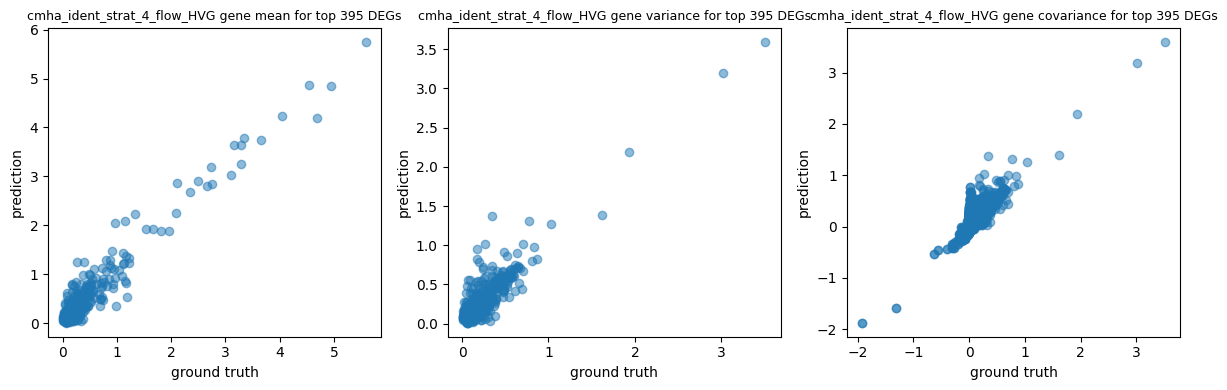

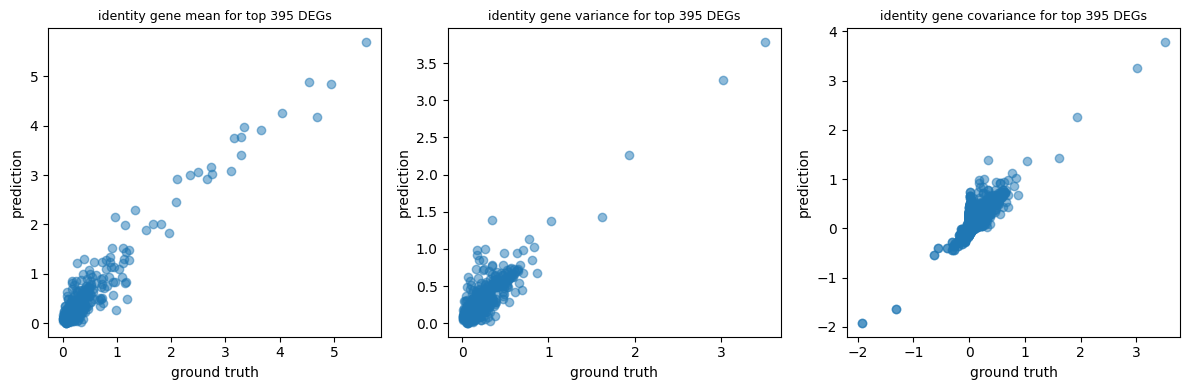

In [32]:
celltype = 'B cells'
for model in predictions.keys():
    plot_comparison(ground_truth_datasets['HVG']['B cells'], predictions[model][celltype], CONDITION_NAME, TARGET,
            DEGs = true_DEGs_dict['HVG'][celltype], model_name = model, DEG_val = 395, clip_pred = False)

In [34]:
def get_DEG_Coverage_Recall(true_DEGs, pred_DEGs, p_cutoff):
    sig_true_DEGs = true_DEGs[true_DEGs['pvals_adj'] < p_cutoff]
    true_DEGs_with_direction = [get_DEG_with_direction(gene,score) for gene, score in zip(sig_true_DEGs.index, sig_true_DEGs['scores'])]
    sig_pred_DEGs = pred_DEGs[pred_DEGs['pvals_adj'] < p_cutoff]
    pred_DEGs_with_direction = [get_DEG_with_direction(gene,score) for gene, score in zip(sig_pred_DEGs.index, sig_pred_DEGs['scores'])]
    num_true_DEGs = len(true_DEGs_with_direction)
    num_pred_DEGs = len(pred_DEGs_with_direction)
    num_overlapping_DEGs = len(set(true_DEGs_with_direction).intersection(set(pred_DEGs_with_direction)))
    COVERAGE = num_overlapping_DEGs/num_true_DEGs
    RECALL = num_overlapping_DEGs/num_pred_DEGs
    return COVERAGE, RECALL

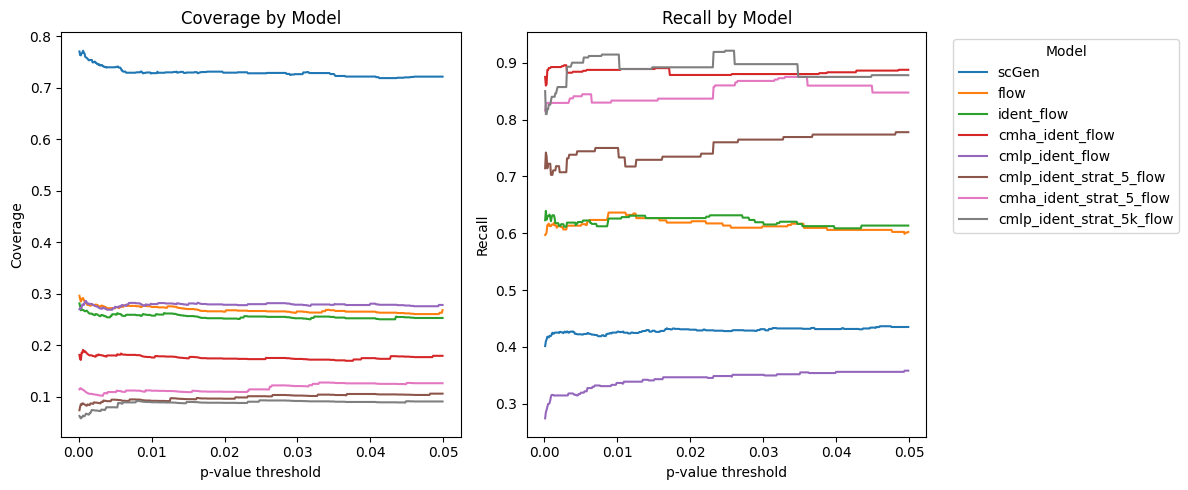

In [35]:
C_R_Results = {}
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
for condition, DEG_dict_temp in all_pred_DEGs.items():
    for celltype in ['B cells']:
        if condition != 'identity':
            C_list = []
            R_list = []
            p_vals = [x/10000 for x in range(1,500)]
            for p in p_vals:
                C, R = (get_DEG_Coverage_Recall(true_DEGs_dict['HVG'][celltype], DEG_dict_temp[celltype], p))
                C_list.append(C)
                R_list.append(R)
            # Plotting Coverage on the first subplot
            ax1.plot(p_vals, C_list, label=condition[0:-4])
            # Plotting Recall on the second subplot
            ax2.plot(p_vals, R_list, label=condition[0:-4])

# Adding titles and labels for the Coverage plot
ax1.set_title("Coverage by Model")
ax1.set_xlabel("p-value threshold")
ax1.set_ylabel("Coverage")
#ax1.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')

# Adding titles and labels for the Recall plot
ax2.set_title("Recall by Model")
ax2.set_xlabel("p-value threshold")
ax2.set_ylabel("Recall")
ax2.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [36]:
df_dict = {}
for condition, DEG_dict_temp in all_pred_DEGs.items():
    DEG_overlap_dict = {}
    for celltype in ['B cells']:#cell_types:
        DEG_overlap_dict[celltype] = eval_DEGs(true_DEGs_dict['HVG'][celltype], 
                                                DEG_dict_temp[celltype], [395, 100, 50, 20])
        
    eval_DEGs_df = pd.DataFrame([val.values() for key, val in DEG_overlap_dict.items()],
                                index = list(DEG_overlap_dict.keys()),
                                columns = list(DEG_overlap_dict[cell_types[0]].keys())
                               ).transpose()
    df_dict[condition] = eval_DEGs_df

pd_results_summary = pd.concat(df_dict.values(),axis=1)
pd_results_summary.columns = [x.replace('_flow','').replace('_HVG','').replace('_',' ') for x in df_dict.keys()]
display(pd_results_summary)

,scGen,flow,ident,cmha ident,cmlp ident,cmlp ident strat 5,cmha ident strat 5,cmlp ident strat 5k,identity
Overlap_in_top_395_DEGs,242,195,196,246,154,206,227,210,53
Overlap_in_top_100_DEGs,57,51,53,67,18,55,64,60,3
Overlap_in_top_50_DEGs,30,30,31,33,8,21,28,25,0
Overlap_in_top_20_DEGs,13,12,13,11,4,6,10,7,0


# Get eval ceilings

In [32]:
new_sample_evals, new_sample_DEGs = sample_within_target(ground_truth_datasets['HVG'], cell_types = ['B cells'], 
                                                    N_samples = 10, sample_size = 500, true_DEG_list = true_DEGs_dict['HVG'], 
                                                    condition_column = CONDITION_NAME, control = CONTROL, target = TARGET)


B cells


/om/group/abugoot/Projects/dlesman/scVI_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/om/group/abugoot/Projects/dlesman/scVI_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/om/group/abugoot/Projects/dlesman/scVI_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/om/group/abugoot/Projects/dlesman/scVI_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/om/group/abugoot/Projects/dlesman/scVI_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/om/group/abugoot/Projects/dlesman/scVI_e

In [33]:
sample_eval_means = [np.array(
    [list(val.values()) for key, val in data.items()]).mean(axis=0) for data in new_sample_evals.values()]
sample_eval_stds = [np.array(
    [list(val.values()) for key, val in data.items()]).std(axis=0) for data in new_sample_evals.values()]

summarized_means_stds = list()
for means, stds in zip(sample_eval_means,sample_eval_stds):
    temp_means_stds = list()
    for mean, std in zip(means,stds):
        temp_means_stds.append(f'{mean:.4f} ± {std:.4f}')
    summarized_means_stds.append(temp_means_stds)

ceiling_R2_df = pd.DataFrame(summarized_means_stds,
                            columns = list(new_sample_evals[cell_types[0]][0].keys()),
                            index = ['B cells']).transpose()

display(rearrange_results_df(ceiling_R2_df, metric = 'R2'))
display(rearrange_results_df(ceiling_R2_df, metric = 'MSE'))

,B cells
all_genes_mean_R2,0.9983 ± 0.0002
Top_500_DEGs_mean_R2,0.9981 ± 0.0003
Top_100_DEGs_mean_R2,0.9991 ± 0.0002
Top_50_DEGs_mean_R2,0.9991 ± 0.0001
Top_20_DEGs_mean_R2,0.9993 ± 0.0002
all_genes_var_R2,0.9891 ± 0.0013
Top_500_DEGs_var_R2,0.9877 ± 0.0018
Top_100_DEGs_var_R2,0.9744 ± 0.0046
Top_50_DEGs_var_R2,0.9677 ± 0.0082
Top_20_DEGs_var_R2,0.9719 ± 0.0153


,B cells
all_genes_mean_MSE,0.0003 ± 0.0000
Top_500_DEGs_mean_MSE,0.0009 ± 0.0001
Top_100_DEGs_mean_MSE,0.0014 ± 0.0003
Top_50_DEGs_mean_MSE,0.0016 ± 0.0003
Top_20_DEGs_mean_MSE,0.0015 ± 0.0006
all_genes_var_MSE,0.0004 ± 0.0001
Top_500_DEGs_var_MSE,0.0011 ± 0.0003
Top_100_DEGs_var_MSE,0.0011 ± 0.0002
Top_50_DEGs_var_MSE,0.0012 ± 0.0003
Top_20_DEGs_var_MSE,0.0013 ± 0.0006


In [28]:
ceiling_subsets_DEG_overlap_dict = {}
for celltype in cell_types:
    n_samples_dict = {}
    for i in range(10):
        n_samples_dict[i] = eval_DEGs(true_DEGs_dict['HVG'][celltype], new_sample_DEGs[celltype][i], 
                                        [500, 100, 50, 20])
    ceiling_subsets_DEG_overlap_dict[celltype] = n_samples_dict

KeyError: 'Myeloid cells'

In [ ]:
model_to_inter_celltype_DEG_intersections = get_inter_celltype_DEG_intersections(true_DEGs_dict, all_pred_DEGs, [100,20])

In [ ]:
for model, DEG_num_to_df in model_to_inter_celltype_DEG_intersections.items():
    for DEG_num, df in DEG_num_to_df.items():
        print(f'model: {model}, DEG_num: {DEG_num}')
        display(df)

In [ ]:
# Get reasonable limit of predicted DEGs

DEG_overlap_means = [np.array(
    [list(val.values()) for key, val in data.items()]).mean(axis=0) for data in ceiling_subsets_DEG_overlap_dict.values()]
DEG_overlap_stds = [np.array(
    [list(val.values()) for key, val in data.items()]).std(axis=0) for data in ceiling_subsets_DEG_overlap_dict.values()]

summarized_DEG_means_stds = list()
for means, stds in zip(DEG_overlap_means, DEG_overlap_stds):
    temp_means_stds = list()
    for mean, std in zip(means,stds):
        temp_means_stds.append(f'{mean} ± {std:.4f}')
    summarized_DEG_means_stds.append(temp_means_stds)

ceiling_DEGs_df = pd.DataFrame(summarized_DEG_means_stds,
            columns = list(ceiling_subsets_DEG_overlap_dict[cell_types[0]][0].keys()),
            index =  cell_types).transpose()

ceiling_DEGs_df

In [52]:
# MELD

In [26]:
#sample_likelihoods, classes = get_meld_labels(OG_datasets['adata_OG_HVG'], 'sm_name', 'Dimethyl Sulfoxide', 'Belinostat')

In [19]:
raw_DEGs = get_DEGs(OG_datasets['adata_OG_HVG'], 'sm_name', 'Dimethyl Sulfoxide', 'Belinostat', meld = False)

In [122]:
#raw_DEGs_flipped = get_DEGs(OG_datasets['adata_OG_HVG'], 'sm_name', 'Belinostat', 'Dimethyl Sulfoxide', meld = False)

In [20]:
meld_DEGs = get_DEGs(OG_datasets['adata_OG_HVG'], 'sm_name', 'Dimethyl Sulfoxide', 'Belinostat', meld = True)

Building graph on 8566 samples and 2000 features.
Calculating graph and diffusion operator...
  Calculating PCA...
  Calculated PCA in 2.06 seconds.
  Calculating KNN search...
  Calculated KNN search in 13.65 seconds.
  Calculating affinities...
  Calculated affinities in 4.03 seconds.
Calculated graph and diffusion operator in 20.03 seconds.
0: 843
1: 3574


In [21]:
meld_DEGs = get_DEGs(OG_datasets['adata_OG_HVG'], 'sm_name', 'Dimethyl Sulfoxide', 'Belinostat', meld = True)

Building graph on 8566 samples and 2000 features.
Calculating graph and diffusion operator...
  Calculating PCA...
  Calculated PCA in 2.04 seconds.
  Calculating KNN search...
  Calculated KNN search in 13.48 seconds.
  Calculating affinities...
  Calculated affinities in 4.06 seconds.
Calculated graph and diffusion operator in 19.86 seconds.
0: 843
1: 3574


In [ ]:
#meld_DEGs_flipped = get_DEGs(OG_datasets['adata_OG_HVG'], 'sm_name', 'Belinostat', 'Dimethyl Sulfoxide', meld = True)

In [25]:
eval_DEGs(raw_DEGs, meld_DEGs, 'Belinostat', '1', [500, 100, 50, 20])

{'Overlap_in_top_500_DEGs': 459,
 'Overlap_in_top_100_DEGs': 91,
 'Overlap_in_top_50_DEGs': 46,
 'Overlap_in_top_20_DEGs': 19}

In [34]:
meld_DEGs_flipped

{'params': {'groupby': 'enhanced_labels',
  'reference': 'rest',
  'method': 'wilcoxon',
  'use_raw': False,
  'layer': None,
  'corr_method': 'benjamini-hochberg'},
 'names': rec.array([('6392',), ('10697',), ('16539',), ..., ('5751',), ('5719',),
            ('9873',)],
           dtype=[('1', 'O')]),
 'scores': rec.array([(-53.979145,), (-53.20424 ,), ( 52.973484,), ...,
            (  0.      ,), (  0.      ,), (  0.      ,)],
           dtype=[('1', '<f4')]),
 'pvals': rec.array([(0.,), (0.,), (0.,), ..., (1.,), (1.,), (1.,)],
           dtype=[('1', '<f8')]),
 'pvals_adj': rec.array([(0.,), (0.,), (0.,), ..., (1.,), (1.,), (1.,)],
           dtype=[('1', '<f8')]),
 'logfoldchanges': rec.array([(-0.87892133,), (-2.1929326 ,), ( 0.6489408 ,), ...,
            ( 0.        ,), ( 0.        ,), ( 0.        ,)],
           dtype=[('1', '<f4')])}

In [44]:
TOP_X = 100

In [45]:
len(set(raw_DEGs['names']['Belinostat'][0:TOP_X]).intersection(set(meld_DEGs['names']['1'][0:TOP_X])))

91

In [153]:
OG_datasets['adata_OG_HVG'].obs['MELD_classes'] = classes

In [154]:
DMSO = (OG_datasets['adata_OG_HVG'].obs['sm_name'] == 'Dimethyl Sulfoxide')
MELD_0 = (OG_datasets['adata_OG_HVG'].obs['MELD_classes'] == 0)
Belinostat = (OG_datasets['adata_OG_HVG'].obs['sm_name'] == 'Belinostat')
MELD_2 = (OG_datasets['adata_OG_HVG'].obs['MELD_classes'] == 2)

In [169]:
labels = list()
for ctrl, drug in zip(((DMSO) & (MELD_0)),((Belinostat) & (MELD_2))):
    if ctrl & drug:
        print('SOMETHING IS VERY WRONG')
        break
    elif ctrl:
        labels.append(0)
    elif drug:
        labels.append(1)
    else:
        labels.append(-1)
print(np.sum(labels))
labels = list()
for ctrl, drug in zip(((DMSO) & (MELD_0)),((Belinostat) & (MELD_2))):
    if ctrl & drug:
        print('SOMETHING IS VERY WRONG')
        break
    elif drug:
        labels.append(1)
    elif ctrl:
        labels.append(0)
    else:
        labels.append(-1)
print(np.sum(labels))

-598
-598


In [172]:
enhanced_control = ((OG_datasets['adata_OG_HVG'].obs['MELD_classes'] == 0) & (OG_datasets['adata_OG_HVG'].obs['sm_name'] == 'Dimethyl Sulfoxide'))
enhanced_target = ((OG_datasets['adata_OG_HVG'].obs['MELD_classes'] == 2) & (OG_datasets['adata_OG_HVG'].obs['sm_name'] == 'Belinostat'))

In [176]:
labels = list()
for ctrl, drug in zip(enhanced_control, enhanced_target):
    if ctrl & drug:
        print('SOMETHING IS VERY WRONG')
        break
    elif ctrl:
        labels.append(0)
    elif drug:
        labels.append(1)
    else:
        labels.append(-1)
print(np.sum(labels))
labels = list()
for ctrl, drug in zip(enhanced_control, enhanced_target):
    if ctrl & drug:
        print('SOMETHING IS VERY WRONG')
        break
    elif drug:
        labels.append(1)
    elif ctrl:
        labels.append(0)
    else:
        labels.append(-1)
print(np.sum(labels))

-8385
-8385


-8385

In [66]:
# Estimate density of each sample over the graph
sample_densities = meld.MELD().fit_transform(
    OG_datasets['adata_OG_HVG'].X, 
    OG_datasets['adata_OG_HVG'].obs['sm_name'])

Building graph on 8566 samples and 2000 features.
Calculating graph and diffusion operator...
  Calculating PCA...
  Calculated PCA in 1.94 seconds.
  Calculating KNN search...
  Calculated KNN search in 11.48 seconds.
  Calculating affinities...
  Calculated affinities in 3.55 seconds.
Calculated graph and diffusion operator in 17.24 seconds.


In [67]:
# Normalize densities to calculate sample likelihoods
sample_likelihoods = meld.utils.normalize_densities(sample_densities)

In [73]:
sc.pp.pca(OG_datasets['adata_OG_HVG'])

In [75]:
OG_datasets['adata_OG_HVG'].obs['likelihood'] = sample_likelihoods['Belinostat']

In [199]:
mixture_model = sklearn.mixture.GaussianMixture(n_components=3)
classes = mixture_model.fit_predict(
    OG_datasets['adata_OG_HVG'].obs['likelihood'].values.reshape(-1,1))

In [200]:
OG_datasets['adata_OG_HVG'].obs['classes'] = classes

/om/group/abugoot/Projects/dlesman/scVI_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/om/group/abugoot/Projects/dlesman/scVI_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


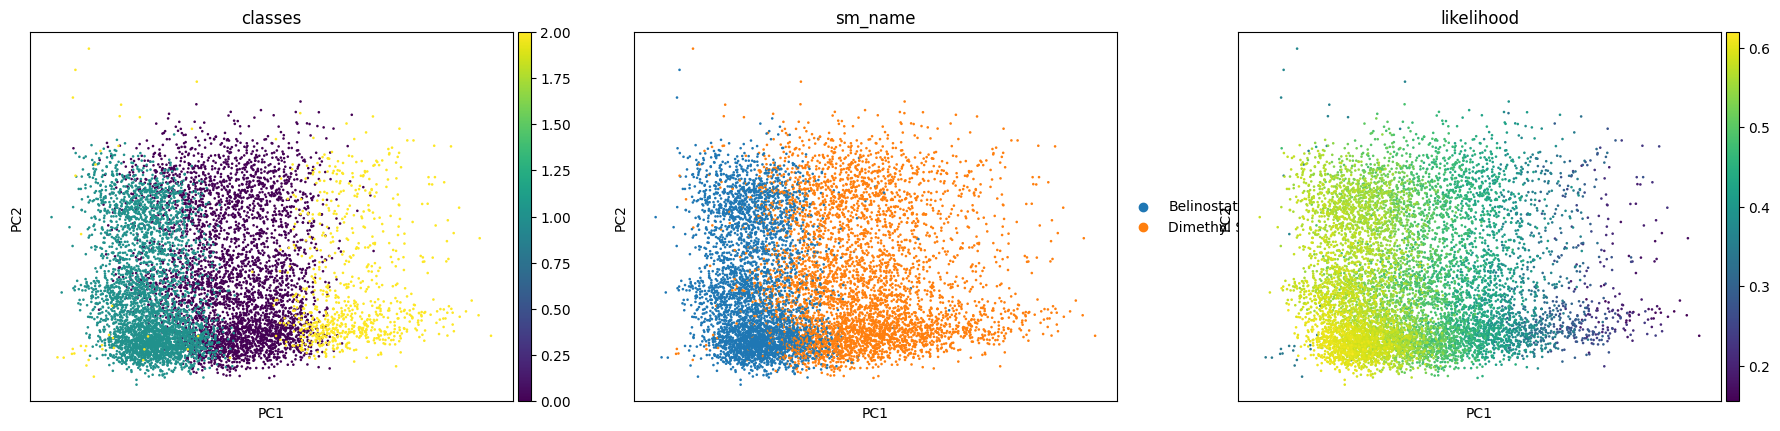

In [201]:
sc.pl.pca(OG_datasets['adata_OG_HVG'], color = ['classes','sm_name','likelihood'])

In [190]:
cell_vals = [100,500,1000,1500]
results_dict = {}
for num_cells in cell_vals:
    results = eval(OG_datasets['adata_OG_HVG'][0:num_cells], 
                   cellot_results['adata_HVG_group'][0:num_cells], 
                   'sm_name', 'Belinostat', DEGs = DEGs, DEG_vals = [500, 100, 50, 20], clip_pred = False)
    results_dict[f'{num_cells} Cells Results'] = results

/om/group/abugoot/Projects/dlesman/scVI_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/om/group/abugoot/Projects/dlesman/scVI_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/om/group/abugoot/Projects/dlesman/scVI_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/om/group/abugoot/Projects/dlesman/scVI_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/om/group/abugoot/Projects/dlesman/scVI_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/om/group/abugoot/Projects/dlesman/scVI_env/lib/python3.9/site-packages/numpy/lib/function_base.py:2

/om/group/abugoot/Projects/dlesman/scVI_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/om/group/abugoot/Projects/dlesman/scVI_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/om/group/abugoot/Projects/dlesman/scVI_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector

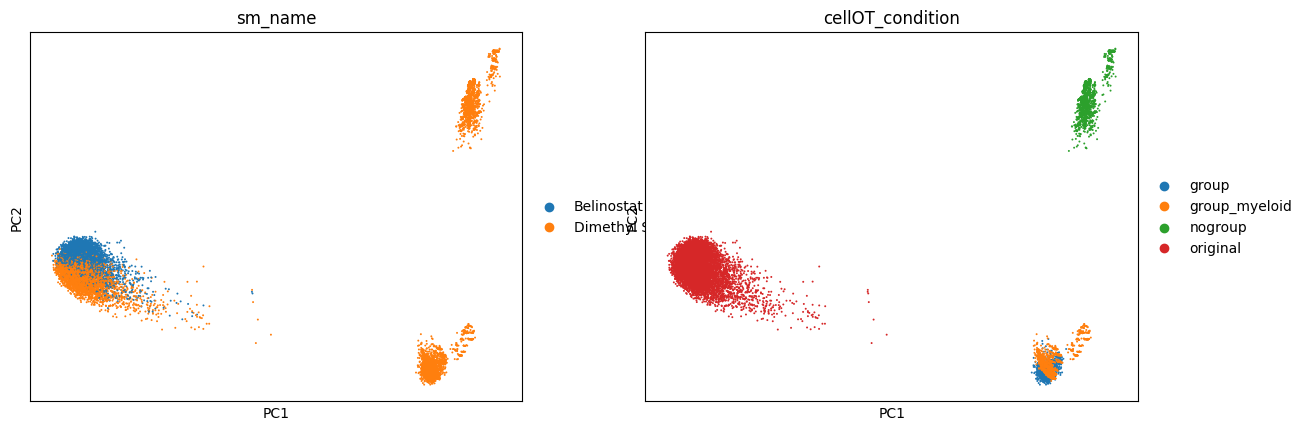

In [180]:
sc.pl.pca(merged_adatas['merged_uce'], color = ['sm_name','cellOT_condition'], components=['1,2'])

/om/group/abugoot/Projects/dlesman/scVI_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/om/group/abugoot/Projects/dlesman/scVI_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/om/group/abugoot/Projects/dlesman/scVI_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector

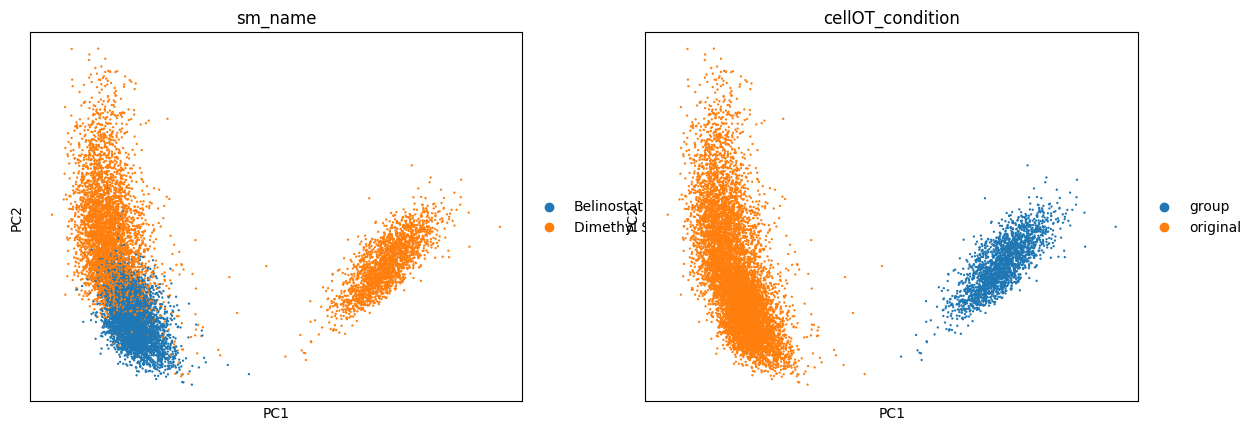

In [181]:
sc.pl.pca(merged_adatas['merged_HVG'], color = ['sm_name','cellOT_condition'], components=['1,2'])